## Import everything, clean tweets, do sentiment analysis

In [2]:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer as cntvec
from sklearn.feature_extraction.text import TfidfTransformer as tftrans
from sklearn.feature_extraction.text import CountVectorizer as cntvec
from sklearn.feature_extraction.text import TfidfTransformer as tftrans
#Silence warnings
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import datetime
import time

In [3]:
#tweets = pd.read_csv(r"C:\Users\Cole\Downloads\politcian_trialdata.csv")

In [4]:
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())





In [5]:
alltweets = pd.read_csv(r"C:\Users\Cole\Downloads\politcian_trialdata.csv")
cleaned = [clean_tweet(tweet) for tweet in alltweets['Text']] 
replaced = [tweet.replace(" amp "," and ") for tweet in cleaned]

In [6]:
replaced

['Talofa National Medal of Honor Day remembers them all on the day the first Medal of Honor was presented in 1963 on March 25th Forever in our nation s history',
 'Talofa March 25 is National Medal of Honor Day We commemorate this day to honor these heroes and thank you to all who serve',
 'Talofa March is National Women s History Month I m happy to be an original cosponsor of a bipartisan Resolution and thank you to these educators from American Samoa',
 'Met with Dennis Murphy the CEO of Health to see how we can work together to help improve price transparency for patients',
 'I spoke at s 2019 Housing Policy Forum to discuss my FairShotAgenda and efforts to solve the housing affordability crisis Learn more in my latest FairShotAgenda video',
 'Enjoyed meeting with my fellow Hoosier U S Surgeon General AdamsMD yesterday afternoon to discuss opioids obesity and other public health issues affecting Indiana I am looking forward to working closely with him in the future',
 'Even the CEO 

In [16]:
print(len(replaced))
#shortlist = replaced[:10]
shortlist = replaced
print(len(shortlist))

1201
1201


In [8]:
# Import the Universal Sentence Encoder's TF Hub module
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
embed = hub.Module(module_url)


Instructions for updating:
Colocations handled automatically by placer.


W0403 18:44:05.888537  5016 deprecation.py:323] From C:\Users\Cole\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [17]:
#embed the shortlist
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  shortlist_embeddings = session.run(embed(shortlist))



In [18]:
shortlist_embeddings.shape

(1201, 512)

In [20]:
 
# Create the pandas DataFrame 
tweet_vectors = pd.DataFrame(replaced, columns = ['Tweet Text']) 

In [21]:
#dataframe with tweet text and its vector
tweet_vectors['Embeddings'] =""
for x in range(0,len(tweet_vectors['Embeddings'])):
    tweet_vectors['Embeddings'][x] = shortlist_embeddings[x]

In [22]:
tweet_vectors

,Tweet Text,Embeddings
0,Talofa National Medal of Honor Day remembers t...,"[-0.046402305, 0.040597565, 0.009848698, -0.04..."
1,Talofa March 25 is National Medal of Honor Day...,"[-0.07178262, -0.0034575337, 0.017161118, -0.0..."
2,Talofa March is National Women s History Month...,"[-0.07631061, -0.032082435, -0.0069021476, 0.0..."
3,Met with Dennis Murphy the CEO of Health to se...,"[0.07039811, 0.04147273, -0.014598503, 0.05701..."
4,I spoke at s 2019 Housing Policy Forum to disc...,"[0.036492635, -0.010356359, -0.0001824695, 0.0..."
5,Enjoyed meeting with my fellow Hoosier U S Sur...,"[0.040404234, 0.036767997, -0.013440338, 0.013..."
6,Even the CEO of AT and T can t escape robocall...,"[-0.0022697244, -0.06428746, 0.00029746385, -0..."
7,As a co chair of the Senate Career and Technic...,"[-0.037764154, 0.023340657, -0.031854615, -0.0..."
8,This morning s HoosierHuddle was a slam dunk T...,"[0.0001282919, -0.027082212, -0.006973437, -0...."
9,As the only Jewish state and the only democrac...,"[0.008485092, 0.014406704, -0.011576429, -0.01..."


In [27]:
# create groups of political topics

list1 = [ "immigration",
"migrant",
"mexican american",
"illegal aliens"]

list2= ["Border wall",
"Border control",
"Border security",
"asylum",
"Drug trafficking"]





In [ ]:
def get_vectors(listname)

    with tf.Session() as session:
      session.run([tf.global_variables_initializer(), tf.tables_initializer()])
      vectors = session.run(embed(listname))
        
        

In [28]:
with tf.Session() as session:
      session.run([tf.global_variables_initializer(), tf.tables_initializer()])
      vectors1 = session.run(embed(list1))

In [30]:
vectors1[0]

array([-0.05764255, -0.04056628, -0.02985646,  0.00050252, -0.0345966 ,
       -0.04646761,  0.08044932,  0.03286963, -0.04100009,  0.02833168,
       -0.0106031 ,  0.06863055, -0.0374272 , -0.05207656, -0.07432756,
       -0.04907571, -0.03016841, -0.0604004 , -0.01335349, -0.02074164,
       -0.05783127, -0.07263386, -0.06861661,  0.04882353, -0.06990728,
        0.06285885, -0.03243125, -0.05497555,  0.02638807,  0.01070389,
        0.05359585, -0.01024063, -0.01096081,  0.06169056, -0.04164403,
        0.02288447, -0.00502091,  0.01293817, -0.01068957, -0.01491865,
        0.05457234, -0.04303622, -0.01093853,  0.04791863, -0.02510827,
        0.04584356,  0.0201135 ,  0.07619665, -0.06657211,  0.03086102,
        0.00250335,  0.05209613,  0.00876115,  0.07861038,  0.04595754,
        0.05797618,  0.06026189, -0.06679967, -0.03357668,  0.01408919,
       -0.03445417, -0.01288977,  0.0631069 , -0.03685528, -0.0228689 ,
       -0.01786405, -0.00055138,  0.0202558 , -0.01067439,  0.06

In [34]:
#take the average vector for all the words in the group
avg_vector1 = vectors1.mean(axis=0)


In [54]:
tweet_vectors['avg_vector1'] = ""
for x in range(0, len(tweet_vectors['avg_vector1'])):
    tweet_vectors['avg_vector1'][x] = avg_vector1
    
tweet_vectors['distance1'] = np.NaN

tweet_vectors['aux'] = tweet_vectors['Embeddings']-tweet_vectors['avg_vector1']
tweet_vectors['distance1'] = np.linalg.norm(tweet_vectors['aux'])

ValueError: Length of values does not match length of index

In [55]:
tweet_vectors['avg_vector1'] = ""
for x in range(0, len(tweet_vectors['avg_vector1'])):
    tweet_vectors['avg_vector1'][x] = avg_vector1
    
tweet_vectors['distance1'] = np.NaN
for x in range(0, len(tweet_vectors['avg_vector1'])):
    tweet_vectors['distance1'][x]= np.linalg.norm(tweet_vectors['Embeddings'][x]-tweet_vectors['avg_vector1'][x])

In [57]:
tweet_vectors.describe()

,distance1
count,1201.000000
mean,1.151987
std,0.067321
min,0.750455
25%,1.112499
50%,1.155960
75%,1.198897
max,1.305275


In [24]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
  message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages_})
  plot_similarity(messages_, message_embeddings_, 90)

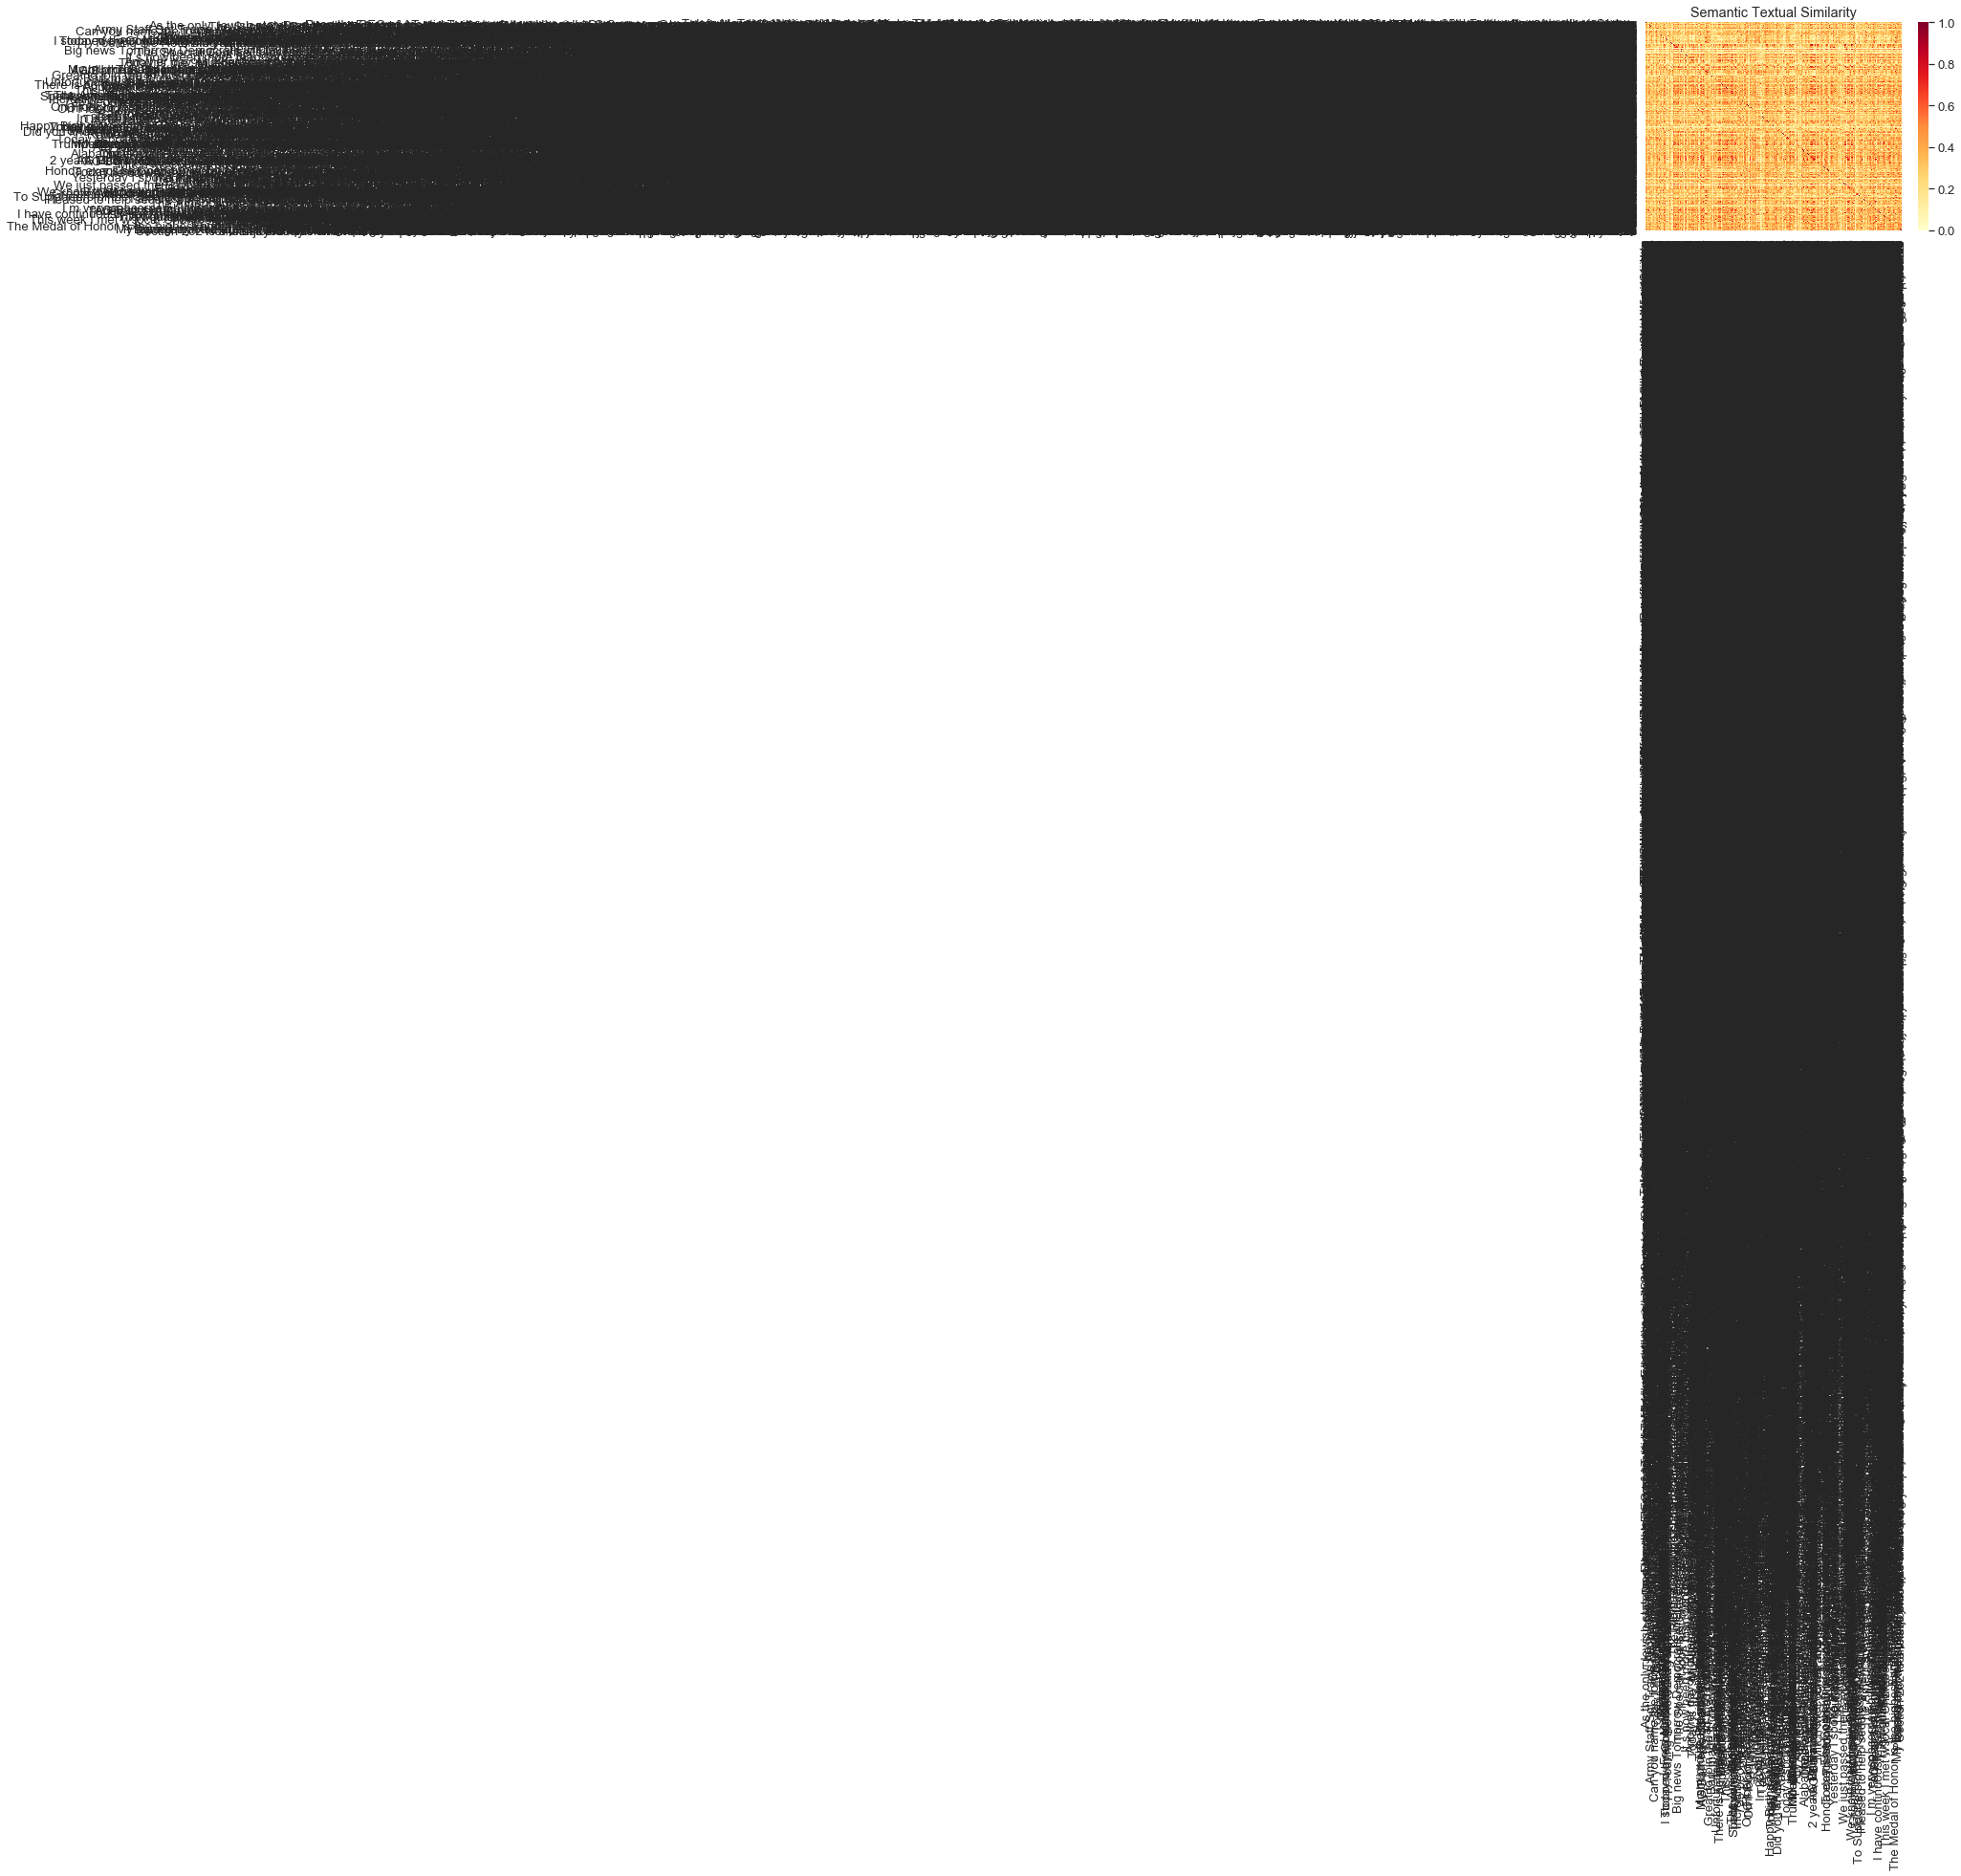

In [25]:
"""messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]"""
messages = replaced

similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  run_and_plot(session, similarity_input_placeholder, messages,
               similarity_message_encodings)